In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

# 2-D prior toy example

> Demonstration of prior error bounds for a 2-D toy example

In this notebook we will demonstrate the error bounds for the statFEM prior for the toy example introduced in <a href="/statFEM/twoDim.html#2-dimensional-case-(PDE)"><code>twoDim</code></a>. We first import some required packages.

In [ ]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
# import required functions from twoDim
from statFEM.twoDim import mean_assembler, kernMat, cov_assembler
from scipy.linalg import sqrtm
import sympy; sympy.init_printing()
from tqdm.notebook import tqdm
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

Since we do not have ready access to a solution operator for this problem we will utilise a different approach to demonstrate the appropriate rate for the error bounds. This approach involves comparing the statFEM distributions on finer and finer meshes as follows. We first assume we have the following error bound:

$$W(\nu_{\star},\nu_{h})\leq\mathcal{O}(h^{p}) \text{ as } h\rightarrow 0$$

From this we have:

$$W(\nu_{\star},\nu_{h})=Ch^{p}+\mathcal{O}(h^{p+1})$$ 

The triangle inequality then yields:

$$W(\nu_{h},\nu_{h/2})\leq W(\nu_{h},\nu_{\star}) + W(\nu_{\star},\nu_{h/2})$$

And so with the above we obtain:

$$W(\nu_{h},\nu_{h/2})=Ch^{p}+C(h/2)^{p}+\mathcal{O}(h^{p+1})$$

Similarly we have:

$$W(\nu_{h/2},\nu_{h/4})=C(h/2)^{p}+C(h/4)^{p}+\mathcal{O}(h^{p+1})$$

Dividing the two above equations yields:

$$\frac{W(\nu_{h},\nu_{h/2})}{W(\nu_{h/2},\nu_{h/4})}=\frac{Ch^{p}+C(h/2)^{p}+\mathcal{O}(h^{p+1})}{C(h/2)^{p}+C(h/4)^{p}+\mathcal{O}(h^{p+1})}=\frac{1-2^{-p}+\mathcal{O}(h)}{2^{-p}-2^{-2p}+\mathcal{O}(h)}=2^{p}+\mathcal{O}(h)$$

From which it follows:

$$\log_{2}\frac{W(\nu_{h},\nu_{h/2})}{W(\nu_{h/2},\nu_{h/4})}=p+\mathcal{O}(h)$$

Note that this ratio above does not rely on having access to the true prior $\nu_{\star}$.

We will thus compare the errors on a succesively refined mesh and take the base-2 log of the above ratio. We hope to see these logarithms converge to $p=2$.

We now set up the mean and kernel functions for the random forcing term $f$.

In [ ]:
# set up mean and kernel functions
f_bar = Constant(1.0)

l_f = 0.4
σ_f = 0.1

def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

We now set up a function to get the statFEM prior for a FE mesh size $h$, using functions from <a href="/statFEM/twoDim.html#"><code>twoDim</code></a>.

In [ ]:
def fem_prior(h,f_bar,k_f,grid):
    J = int(np.round(1/h))
    μ = mean_assembler(h,f_bar)
    Σ = cov_assembler(J,k_f,grid,False,True)
    return μ,Σ

We now set up a reference grid on which we will compare the covariance matrices.

In [ ]:
N = 41
x_range = np.linspace(0,1,N)
grid = np.array([[x,y] for x in x_range for y in x_range])

We now set up a function to compare the covariance functions on the reference grid.

In [ ]:
def compute_cov_diff(C1,C2,tol=1e-10):
    N = np.sqrt(C1.shape[0])
    #N = C1.shape[0]
    C1_sqrt = np.real(sqrtm(C1))
    rel_error_1 = np.linalg.norm(C1_sqrt @ C1_sqrt - C1)/np.linalg.norm(C1)
    assert rel_error_1 < tol
    
    C12 = C1_sqrt @ C2 @ C1_sqrt
    C12_sqrt = np.real(sqrtm(C12))
    rel_error_12 = np.linalg.norm(C12_sqrt @ C12_sqrt - C12)/np.linalg.norm(C12)
    assert rel_error_12 < tol
    
    hSq = (1/(N-1))**2
    return hSq*(np.trace(C1) + np.trace(C2) - 2*np.trace(C12_sqrt))

We now set up a function to compute the Wasserstein distance between the statFEM priors.

In [ ]:
def W(μ_1,μ_2,Σ_1,Σ_2):
    mean_error = errornorm(μ_1,μ_2,'L2')
    cov_error = compute_cov_diff(Σ_1,Σ_2)
    cov_error = np.sqrt(np.abs(cov_error))
    error = mean_error + cov_error
    return error

In the interests of memory efficiency we will now create a function which will compute the ratios of errors mentioned above by succesively refining the FE mesh.

In [ ]:
def refine(h,n,f_bar,k_f,grid):
    # set up empty lists to hold h-values and errors (this being the ratios)
    h_range = []
    errors = []
    # get the statFEM prior for h and h/2
    μ_1, Σ_1 = fem_prior(h,f_bar,k_f,grid)
    μ_2, Σ_2 = fem_prior(h/2,f_bar,k_f,grid)
    # compute the distance between these and store in numerator variable
    numerator = W(μ_1,μ_2,Σ_1,Σ_2)
    # succesively refine the mesh by halving and do this n times
    for i in tqdm(range(n)):
        # store mean and cov for h/2 in storage for h
        μ_1, Σ_1 = μ_2, Σ_2 
        # in storage for h/2 store mean and cov for h/4
        μ_2, Σ_2 = fem_prior(h/4,f_bar,k_f,grid)
        # compute the distance between the priors for h/2 and h/4
        # and store in denominator variable
        denominator = W(μ_1,μ_2,Σ_1,Σ_2)
        # compute the ratio and store in error
        error = numerator/denominator
        # append the current value of h and the ratio
        h_range.append(h)
        errors.append(error)
        # store denominator in numerator and halve h
        numerator = denominator
        h = h/2
    # return the list of h-values together with the ratios for these values
    return h_range,errors

> Note: The above function will compute the ratio $\frac{W(\nu_{h},\nu_{h/2})}{W(\nu_{h/2},\nu_{h/4})}$ for the values $h,h/2,\cdots,h/2^{n-1}$.

We now set up a list of starting $h$ values and number of refinements $n$ to get a decent number of ratios to approximate $p$.

In [ ]:
my_list = [(0.25,4),(0.2,3),(0.175,3),(0.22,4),(0.176,3),(0.177,3),(0.178,3),(0.179,3),(0.18,3),(0.21,3),(0.215,3),(0.1,2),(0.3,4),(0.31,4),(0.315,4),(0.24,4),(0.245,4),(0.25,4),(0.14,2),(0.16,2),(0.15,2),(0.18,2)]

> Warning: As we are now in 2-D the matrices needed to compute the statFEM prior get very large in size as $h$ decreases. Due to memory constraints we must thus make sure $h$ does not get too small.

We now compute the results:

In [ ]:
%%time
h_range = []
errors = []
for h,n in tqdm(my_list,desc = 'Outer loop'):
    h_range_tmp, errors_tmp = refine(h,n,f_bar,k_f,grid)
    h_range.extend(h_range_tmp)
    errors.extend(errors_tmp)

Outer loop:   0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1h 15min 42s, sys: 43min 30s, total: 1h 59min 12s
Wall time: 31min 30s


In [ ]:
#hide
# import pickle
# results = {'h':h_range,'ratios':errors}
# with open('2D_prior_results_finer','wb') as f:
#     pickle.dump(results,f)

In [ ]:
#hide
import pickle
with open('2D_prior_results_finer','rb') as f:
    results = pickle.load(f)
h_range = results['h']
errors = results['ratios']

We now sort these results by $h$ and get rid of duplicates (from repeats in $h$-values).

In [ ]:
h_range_array = np.array(h_range)
errors_array = np.array(errors)

In [ ]:
argInd = np.argsort(h_range_array)
hs = h_range_array[argInd]
es = errors_array[argInd]
hs,hs_ind = np.unique(hs,return_index=True)
es = es[hs_ind]

We now plot the base-2 logarithm of the ratios against $h$ below:

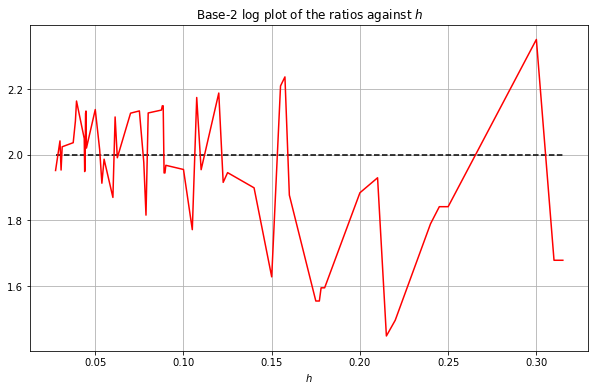

In [ ]:
#hide_input
plt.plot(hs,np.log2(es),c='r')
plt.xlabel('$h$')
plt.title('Base-2 log plot of the ratios against $h$')
plt.hlines(2.0,hs[0],hs[-1],colors='black',linestyles='--')
plt.grid()
plt.savefig('2D_prior_results.png',dpi=300,bbox_inches='tight',facecolor='w')
plt.show()

We can see from the above plot that the logarithms seems to be approaching $p=2$ as $h$ gets small just as predicted. However, the results aren't that smooth and they haven't seemed to settle on $p=2$ yet. This can be due to memory constraints meaning we cannot use small enough $h$. We thus smooth the above results via two approaches:

- We take a cumulative average of the ratios and then apply $\log_2$.
- We first apply $\log_2$ to the ratios and then taking a cumulative average.

In both cases we take the rolling average starting with large $h$. We choose a cut-off point of $h=0.15$, i.e. we discard any results for $h>0.15$.

The results are shown below:

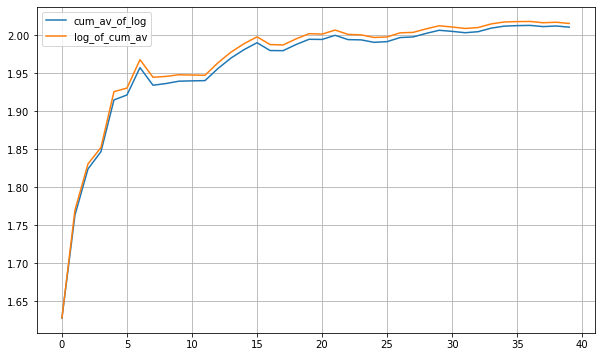

In [ ]:
#hide_input
# get the cumulative average of es:
i = -19
ES = es[:i]
es_av = np.cumsum(np.log2(ES[::-1]))/np.arange(1,len(ES)+1)
es_av_1 = np.log2(np.cumsum(ES[::-1])/np.arange(1,len(ES)+1))
plt.plot(es_av,label='cum_av_of_log')
#plt.plot(es_av_1,label='log_of_cum_av',c='r')
plt.plot(es_av_1,label='log_of_cum_av')
#plt.hlines(2.0,0,len(es_av_1),colors='black',linestyles='--')
#plt.title('Base-2 logarithms of the cumulative averages of the ratios for $h\leq 0.15$')
#plt.xlabel('index')
#plt.ylim((1.8,2.1))
plt.legend()
plt.grid()
#plt.savefig('2D_prior_results_smoothed.png',dpi=300,bbox_inches='tight',facecolor='w')
plt.show()

From the smoothed results above we can see more clearly that the ratios are converging to around $p=2$. In fact, discarding the values corresponding to $h>0.15$ seems to result in the the rolling average converging to a value slightly greater than $2$.

In [ ]:
#hide
# import pickle
# results = {'h':h_range,'ratios':errors}
# with open('2D_prior_results','wb') as f:
#     pickle.dump(results,f)